## Functional connectivity

This notebook extracts individual connectivity matrices of the networks defined in [@dosenbach2007], [@dosenbach2010], and [@difumo2018] atlases. The connectivity matrix, of shape $N_{\text{subjects}} \times N_{\text{regions}} \times N_{\text{regions}}$, will be stored in annotated NetCDF4 files in the following paths:

- `data/julia2018_resting/connectivity_dosenbach2007.nc`.
- `data/julia2018_resting/connectivity_dosenbach2010.nc`.
- `data/julia2018_resting/connectivity_difumo_64_2.nc`.
- `data/julia2018_resting/connectivity_difumo_128_2.nc`.
- `data/julia2018_resting/connectivity_difumo_1024_2.nc`.

## Setup

We require the following packages: `nilearn`, `XArray`, and `NetCDF4`.

In [1]:
%reload_ext autoreload
%autoreload 3

from typing import Tuple

from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr

from python.acnets.connectome import ExtraConnectivityMeasure

Load the time-series of the cognitive control network:

In [2]:
DATASETS = dict.fromkeys([
  'dosenbach2007',
  'dosenbach2010',
  'difumo_64_2',
  # 'difumo_128_2',
  # 'difumo_1024_2'
  ], None)

# load the datasets
DATASETS = {
  ds_name: xr.open_dataset(f'data/julia2018_resting/timeseries_{ds_name}.nc')
  for ds_name in DATASETS.keys()}

## Fit connectivity matrices


In [3]:
def get_valid_timeseries(timeseries: xr.DataArray) -> Tuple[np.ndarray, list[np.ndarray]]:
  """Discard subjects with missing resting time-series.
  
  Returns:
    - mask : np.ndarray
      boolean array of shape (n_subjects, n_times)
    - valid_timeseries : list[np.ndarray]
      list of valid time-series, one item per subject.
  """

  missing_mask = timeseries.isnull().all(dim=['region','timestep'])
  valid_timeseries = [ts.T for ts in timeseries.values[~missing_mask]]
  return missing_mask, valid_timeseries


# some subjects are missing resting time-series, so we need to filter them out.
timeseries = {
  key: get_valid_timeseries(ds['timeseries'])
  for key, ds in DATASETS.items()
}

In [4]:
# iterate over atlases and connectivity kinds and calculate them

conn_kinds = ['covariance', 'correlation', 'partial correlation',
              'chatterjee', 'transfer_entropy',
              'tangent', 'precision', ]

for ds_name, (missing_mask, valid_timeseries) in timeseries.items():
  
  dataset = DATASETS[ds_name]
  dataset.attrs['description'] = f'Resting state connectivity matrices for {ds_name}'
  missing_indices = np.flatnonzero(missing_mask)
  
  for kind in tqdm(conn_kinds, desc=ds_name):
    
    # calculate connectivity measure
    cm = ExtraConnectivityMeasure(kind=kind, vectorize=False)
    conn = cm.fit_transform(valid_timeseries)
    
    # now refill the places of the missing time-series with nan values
    nan_insertion_indices = missing_indices - np.arange(missing_indices.shape[0])
    conn = np.insert(conn, nan_insertion_indices, np.full_like(conn[0], np.nan), axis=0)

    # DEBUG: just to make sure missing values are handled correctly
    assert np.equal(np.isnan(conn).all(axis=(1,2)), missing_mask).all()

    # add to the dataset
    ds_key_name = kind.replace(' ', '_') + '_connectivity'
    dataset[ds_key_name] = xr.DataArray(conn, dims=['subject', 'region', 'region'])

  # now store the dataset
  dataset.to_netcdf(f'data/julia2018_resting/connectivity_{ds_name}.nc', engine='netcdf4')
  print(f'{ds_name} connectivity saved successfully.')

dosenbach2007: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


dosenbach2007 connectivity saved successfully.


dosenbach2010: 100%|██████████| 7/7 [02:36<00:00, 22.32s/it]


dosenbach2010 connectivity saved successfully.


difumo_64_2: 100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


difumo_64_2 connectivity saved successfully.


<AxesSubplot:>

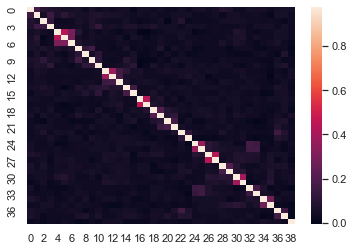

In [93]:
import seaborn as sns; sns.set()

X = DATASETS['dosenbach2007']['timeseries'].values
X = [x.transpose(1,0) for x in X]
conn = ExtraConnectivityMeasure(kind='chatterjee').fit_transform(X)

sns.heatmap(conn.mean(0))